In [1]:
!nvidia-smi

Wed Jan  4 08:24:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   25C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1D.0 Off |                    0 |
| N/A   

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import torchvision
import torchvision.transforms as transforms

In [8]:
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:04<00:00, 34456229.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [9]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
trainloader = torch.utils.data.DataLoader(trainset , batch_size=4 , shuffle=True)

In [12]:
dataiter = iter(trainloader)
images,labels = next(dataiter)

print(images.shape)

torch.Size([4, 3, 32, 32])


In [14]:
img=images[0]
print(type(img))
npimg=img.numpy()
print(type(npimg))
print(npimg.shape)

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(3, 32, 32)


In [15]:
npimg=np.transpose(npimg,(1,2,0))
print(npimg.shape)

(32, 32, 3)


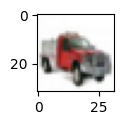

In [16]:
plt.figure(figsize=(1,1))
plt.imshow(npimg)
plt.show()

In [17]:
def imshow(img):
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

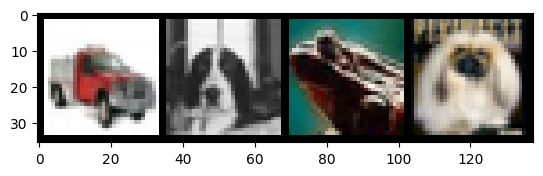

truck dog frog dog


In [18]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))

In [21]:
# device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


In [23]:
import torch.nn as nn

In [24]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet,self).__init__()
    self.cnn_model=nn.Sequential(
        nn.Conv2d(3,6,5),         #(N,3,32,32)->(N,6,28,28)
        nn.Tanh(),
        nn.AvgPool2d(2,stride=2), #(N,6,28,28)->(N,6,14,14)
        nn.Conv2d(6,16,5),        #(N,6,14,14)->(N,16,10,10)
        nn.Tanh(),
        nn.AvgPool2d(2,stride=2)  #(N,16,10,10)->(N,16,5,5)  ,  total no.of features per image=16*5*5=400 
    )
    self.fc_model=nn.Sequential(
        nn.Linear(400,120),       #(N,400)->(N,120)
        nn.Tanh(),
        nn.Linear(120,84),        #(N,120)->(N,84)
        nn.Tanh(),
        nn.Linear(84,10)          #(N,84)->(N,10)
    )

  def forward(self,x):
    #print(x.shape)
    x=self.cnn_model(x)
    #print(x.shape)
    x=x.view(x.size(0),-1)
    #print(x.shape)
    x=self.fc_model(x)
    #print(x.shape)
    return x

In [25]:
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
def evaluation(dataloader):  #for computing accuracy
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [27]:
net=LeNet()

In [28]:
import torch.optim as optim

loss_fn=nn.CrossEntropyLoss()
opt=optim.Adam(net.parameters())

epoch : 0/1, Test acc : 10.00, Train acc : 10.00


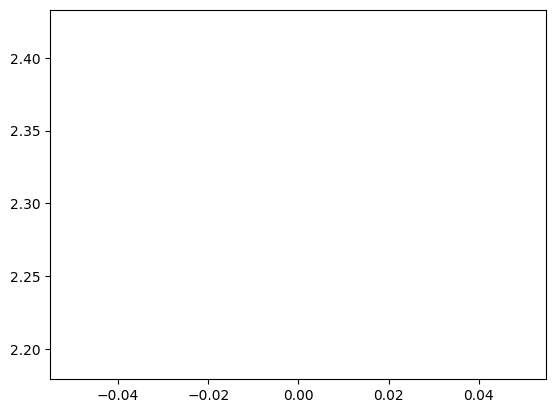

CPU times: user 1min 49s, sys: 2.85 s, total: 1min 52s
Wall time: 20.9 s


In [29]:
%%time
loss_arr=[]
loss_epoch_arr=[]
max_epochs=1

for epoch in range(max_epochs):
  for i,data in enumerate(trainloader,0):
    
    inputs,labels=data

    opt.zero_grad()

    outputs=net(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    opt.step()

    loss_arr.append(loss.item())
    break

  loss_epoch_arr.append(loss.item())

  print('epoch : %d/%d, Test acc : %0.2f, Train acc : %0.2f' % (epoch,max_epochs,evaluation(testloader),evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [31]:
def evaluation(dataloader):  #for computing accuracy
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device),labels.to(device)
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [32]:
net=LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

epoch : 0/16, Test acc : 38.74, Train acc : 38.55
epoch : 1/16, Test acc : 44.28, Train acc : 44.31
epoch : 2/16, Test acc : 47.98, Train acc : 48.39
epoch : 3/16, Test acc : 49.12, Train acc : 50.51
epoch : 4/16, Test acc : 49.82, Train acc : 51.64
epoch : 5/16, Test acc : 52.11, Train acc : 54.75
epoch : 6/16, Test acc : 52.94, Train acc : 55.63
epoch : 7/16, Test acc : 52.80, Train acc : 56.96
epoch : 8/16, Test acc : 53.96, Train acc : 58.81
epoch : 9/16, Test acc : 54.50, Train acc : 59.46
epoch : 10/16, Test acc : 54.65, Train acc : 60.92
epoch : 11/16, Test acc : 54.85, Train acc : 61.59
epoch : 12/16, Test acc : 55.13, Train acc : 62.70
epoch : 13/16, Test acc : 55.32, Train acc : 63.49
epoch : 14/16, Test acc : 55.42, Train acc : 64.58
epoch : 15/16, Test acc : 55.65, Train acc : 65.09


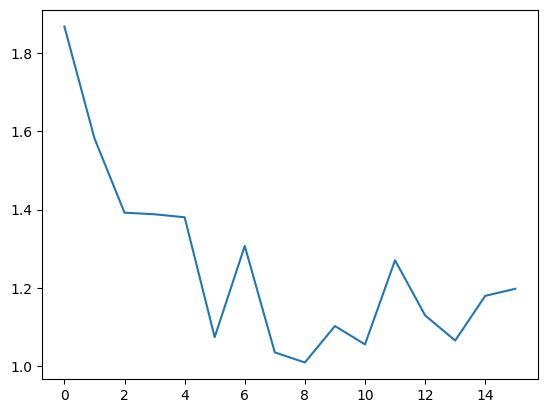

CPU times: user 4min 14s, sys: 1.12 s, total: 4min 15s
Wall time: 4min 8s


In [33]:
%%time
loss_arr=[]
loss_epoch_arr=[]
max_epochs=16

for epoch in range(max_epochs):
  for i,data in enumerate(trainloader,0):
    
    inputs,labels=data
    inputs,labels=inputs.to(device),labels.to(device)

    opt.zero_grad()

    outputs=net(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    opt.step()

    loss_arr.append(loss.item())

  loss_epoch_arr.append(loss.item())

  print('epoch : %d/%d, Test acc : %0.2f, Train acc : %0.2f' % (epoch,max_epochs,evaluation(testloader),evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()